# LLM Inference: How Language Models Work

LLMs are just classifiers that predict the next token from ~50k possibilities.

In [ ]:
%pip install torch transformers tokenizers -qqq

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using: {device}")

/Users/farishijazi/Downloads/ai_pros_week1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using: mps


## Load Model

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device).eval()

## Architecture

GPT-2 is a decoder-only transformer: embeddings → 12 transformer blocks → linear head

In [4]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [5]:
print(f"Vocab size: {model.config.vocab_size:,}")
print(f"Embedding dim: {model.config.n_embd}")
print(f"Layers: {model.config.n_layer}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Vocab size: 50,257
Embedding dim: 768
Layers: 12
Parameters: 124,439,808


## Tokenization

Text → token IDs → tensor

In [6]:
text = "Hello, I am a language model."

# Encode: text -> IDs
token_ids = tokenizer.encode(text)
print(f"Token IDs: {token_ids}")

# See each token
for tid in token_ids:
    print(f"  {tid:5d} -> '{tokenizer.decode([tid])}'")

Token IDs: [15496, 11, 314, 716, 257, 3303, 2746, 13]
  15496 -> 'Hello'
     11 -> ','
    314 -> ' I'
    716 -> ' am'
    257 -> ' a'
   3303 -> ' language'
   2746 -> ' model'
     13 -> '.'


In [7]:
# Decode: IDs -> text
tokenizer.decode(token_ids)

'Hello, I am a language model.'

## Forward Pass

Input tokens → model → logits (scores for each vocab token)

In [8]:
prompt = "The capital of France is"
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

with torch.no_grad():
    outputs = model(input_ids)

logits = outputs.logits
print(f"Input shape: {input_ids.shape}  # (batch, seq_len)")
print(f"Output shape: {logits.shape}  # (batch, seq_len, vocab_size)")

Input shape: torch.Size([1, 5])  # (batch, seq_len)
Output shape: torch.Size([1, 5, 50257])  # (batch, seq_len, vocab_size)


In [9]:
# Logits for predicting next token (last position)
next_token_logits = logits[0, -1, :]  # shape: (50257,)

# Top predictions
top_logits, top_ids = next_token_logits.topk(10)
for logit, tid in zip(top_logits, top_ids):
    print(f"{logit.item():7.2f} -> '{tokenizer.decode([tid])}'")

-100.25 -> ' the'
-100.82 -> ' now'
-100.86 -> ' a'
-101.21 -> ' France'
-101.21 -> ' Paris'
-101.41 -> ' in'
-101.41 -> ' also'
-101.52 -> ' not'
-101.54 -> ' home'
-101.95 -> ' still'


## Logits → Probabilities (Softmax)

In [10]:
probs = F.softmax(next_token_logits, dim=-1)

top_probs, top_ids = probs.topk(10)
for prob, tid in zip(top_probs, top_ids):
    print(f"{prob.item()*100:5.2f}% -> '{tokenizer.decode([tid])}'")

 8.46% -> ' the'
 4.79% -> ' now'
 4.62% -> ' a'
 3.24% -> ' France'
 3.22% -> ' Paris'
 2.66% -> ' in'
 2.64% -> ' also'
 2.38% -> ' not'
 2.33% -> ' home'
 1.55% -> ' still'


## Temperature

`softmax(logits / temperature)`

- T < 1: sharper (more confident)
- T = 1: normal
- T > 1: flatter (more random)

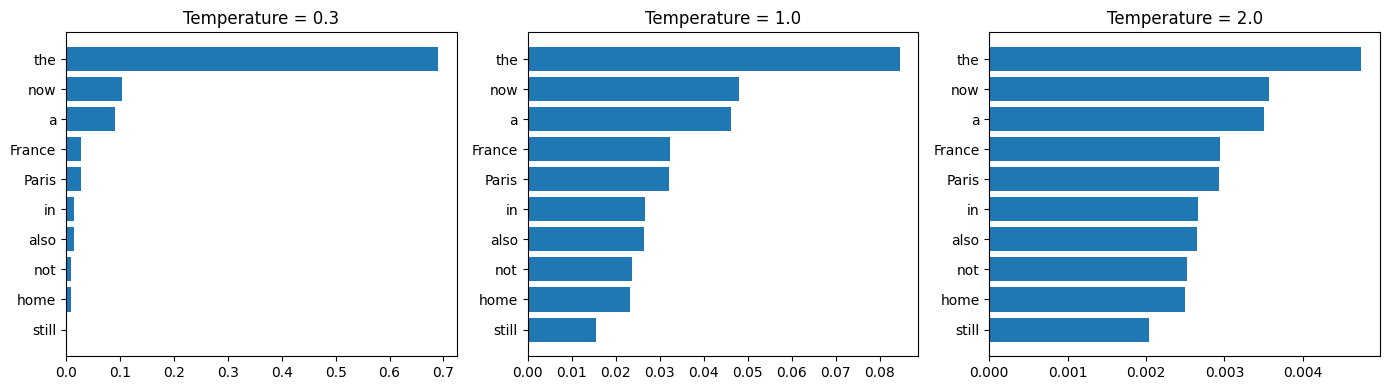

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, temp in zip(axes, [0.3, 1.0, 2.0]):
    probs = F.softmax(next_token_logits / temp, dim=-1)
    top_probs, top_ids = probs.topk(10)
    tokens = [tokenizer.decode([tid]).strip() for tid in top_ids]
    
    _ = ax.barh(range(len(tokens)), top_probs.cpu().numpy())
    _ = ax.set_yticks(range(len(tokens)))
    _ = ax.set_yticklabels(tokens)
    _ = ax.set_title(f'Temperature = {temp}')
    _ = ax.invert_yaxis()

plt.tight_layout()
plt.show()

## Sampling: Greedy vs Random

In [12]:
# Greedy: always pick highest prob
greedy_token = next_token_logits.argmax()
print(f"Greedy: '{tokenizer.decode([greedy_token])}'")

# Random: sample from distribution
probs = F.softmax(next_token_logits, dim=-1)
sampled_token = torch.multinomial(probs, num_samples=1)
print(f"Sampled: '{tokenizer.decode(sampled_token)}'")

Greedy: ' the'
Sampled: ' a'


## Generation Loop

The complete process: encode → forward → sample → append → repeat

In [13]:
prompt = "Once upon a time"
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
temperature = 0.8
max_tokens = 30

print(prompt, end="")

for _ in range(max_tokens):
    # Forward pass
    with torch.no_grad():
        logits = model(input_ids).logits[0, -1, :]
    
    # Sample with temperature
    probs = F.softmax(logits / temperature, dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    
    # Append and print
    input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)
    print(tokenizer.decode([next_token.item()]), end="", flush=True)

print()

Once upon a time of quaking, the thunder of mankind's cruel thunder had been broken. Only ten years ago, when a fire had been built and its blaze destroyed


## Summary

1. **Tokenize**: text → token IDs
2. **Forward**: IDs → logits (50k scores)
3. **Softmax**: logits → probabilities
4. **Sample**: pick next token
5. **Repeat**: append token, go to step 2

That's it. LLMs are just next-token classifiers run in a loop.